# FACE TRACKER WORKFLOW

## 1. Utiliser un modèle de Tensorflow HUB
> ### - Ce modèle c'est un CNN (Convolutionnal Neural Network)
> ### - Ce modèle sera Utilisé comme extracteur de caracteristiques

## 2. Utiliser un modèle de OpenCV
> ### - Ce modèle sera Utilisé comme detecteur de visage (face detector)
> ### - Ce modèle sera permettra de detecter plusieurs visages dans une image

## 3. Calculer le vecteur de l'image cible (visage à chercher)
> ### - Grace au modèle CNN de Tensorflow HUB

## 4. Calculer le vecteur de l'image de comparaison
> ### - Grace au modèle CNN de Tensorflow HUB
> ### - S'il y a plusieurs visage, faire cette opération pour chaque visage

## 5. Faire la classification vectorielle
> ### - Après avoir calculer le vecteur de l'image cible et de l'image de comparaison
> ### - Calculer la distance qui separe ces deux vecteurs
> ### - Plus la distance est proche de 0 et plus les deux visages sont identiques (0 pour dire visage 100% identique)




# TensorFlow Hub and Transfer Learning

[TensorFlow Hub](http://tensorflow.org/hub) est un référentiel en ligne de modèles TensorFlow déjà formés que vous pouvez utiliser.
Ces modèles peuvent être utilisés tels quels, ou bien ils peuvent être utilisés pour l'apprentissage par transfert.

Le transfert d'apprentissage est un processus dans lequel vous prenez un modèle déjà formé et l'étendez pour faire un travail supplémentaire. Cela implique de laisser la majeure partie du modèle inchangée, tout en ajoutant et en recyclant les couches finales, afin d'obtenir un ensemble différent de résultats possibles.

Dans ce Colab, nous allons faire les deux.

Ici, vous pouvez voir tous les modèles disponibles dans [TensorFlow Module Hub](https://tfhub.dev/).

# Imports

Ce Colab va nous obliger à utiliser certaines choses qui ne sont pas encore dans les versions officielles de TensorFlow. Donc ci-dessous, nous installons d'abord une version nocturne de TensorFlow ainsi que le Hub TensorFlow.

Certaines importations normales que nous avons déjà vues. Le nouveau est l'importation de tensorflow_hub qui a été installé ci-dessus, et dont ce Colab fera un usage intensif.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

In [49]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import numpy as np
import PIL.Image as Image

In [8]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Part 1: Use a TensorFlow Hub MobileNet for prediction

Dans cette partie du Colab, nous allons prendre un modèle entraîné, le charger dans Keras et l'essayer.

Le modèle que nous utiliserons est MobileNet v2 (mais n'importe quel modèle de [tf2 compatible image classifier URL from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) fonctionnerait).

# Partie 1 : Utiliser un modele TensorFlow HUB comme feature extractor

Utilisons maintenant le Hub TensorFlow pour faire de l'apprentissage par transfert.

Avec l'apprentissage par transfert, nous réutilisons des parties d'un modèle déjà formé et changeons la couche finale, ou plusieurs couches, du modèle, puis nous recyclons ces couches sur notre propre jeu de données.

En plus des modèles complets, TensorFlow Hub distribue également des modèles sans la dernière couche de classification. Ceux-ci peuvent être utilisés pour faire facilement de l'apprentissage de transfert. Nous continuerons à utiliser MobileNet v2 car dans les parties ultérieures de ce cours, nous prendrons ce modèle et le déploierons sur un appareil mobile en utilisant [TensorFlow Lite](https://www.tensorflow.org/lite). N'importe quel [URL de vecteur de caractéristique d'image de tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) fonctionnerait ici.

Nous continuerons également à utiliser le jeu de données Dogs vs Cats, ce qui nous permettra de comparer les performances de ce modèle avec celles que nous avons créées de toutes pièces auparavant.

Notez que nous appelons le modèle partiel de TensorFlow Hub (sans la couche de classification finale) un `feature_extractor`. Le raisonnement pour ce terme est qu'il va prendre l'entrée jusqu'à une couche contenant un certain nombre de fonctionnalités. Il a donc fait le gros du travail d'identification du contenu d'une image, sauf pour la création de la distribution de probabilité finale. C'est-à-dire qu'il a extrait les caractéristiques de l'image.

## Télécharger le classificateur

Téléchargez le modèle MobileNet et créez un modèle Keras à partir de celui-ci.
MobileNet attend des images de 224 $\times$ 224 pixels, en 3 canaux de couleur (RGB).

In [11]:
IMAGE_RES = 224

In [43]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(IMAGE_RES, IMAGE_RES, 3), trainable=False)

## Envelopper la couche d'extration de caracteristique dans un model keras 

Enveloppez maintenant le calque de hub dans un modèle `tf.keras.Sequential`, et sans ajoutez un nouveau calque de classification.

In [46]:
model = tf.keras.Sequential([
  feature_extractor_layer
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


# Partie 2 : Utiliser un modèle de OpenCV (face detector)

# 3. Calculer le vecteur d'une image

## Fonction qui permet de calculer le features map (vecteur) d'une image

In [70]:
def extractFeatureMap(model, image:np.array) -> np.array:
    assert image.shape == (IMAGE_RES, IMAGE_RES, 3)

    # make a copy
    imageCopy = np.copy(image)

    # Image Preprocessing

    # normalization
    imageCopy = np.array(imageCopy) / 255.0

    # add batch
    imageCopy = imageCopy[np.newaxis, ...]

    # make inference
    imageVectors = model.predict(targetImageBatch)

    return imageVectors[0]







## Image cible (224, 224, 3)

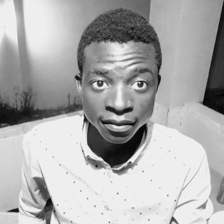

In [74]:
nathanBangwa243 = os.path.join(os.getcwd(), "images", "nathanBangwa243.jpg")
targetImage = Image.open(nathanBangwa243).resize((IMAGE_RES, IMAGE_RES))

targetImage


## Transfom to numpy array (224, 224, 3)

In [75]:
targetImage = np.array(targetImage)
targetImage.shape

(224, 224, 3)

## 3. Calculer le vecteur de l'image cible

In [79]:
targetImageVector = extractFeatureMap(model, targetImage)
targetImageVector

array([0.02216934, 0.        , 0.        , ..., 0.36574665, 0.38928717,
       0.        ], dtype=float32)

In [80]:
targetImageVector.shape

(1280,)

## 4. Calculer le vecteur de l'image de comparaison

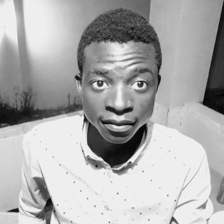

In [82]:
nathanBangwa243 = os.path.join(os.getcwd(), "images", "nathanBangwa243.jpg")
CompareImage = Image.open(nathanBangwa243).resize((IMAGE_RES, IMAGE_RES))

CompareImage


## Calculer le vecteur de l'image cible

In [83]:
compareImageVector = extractFeatureMap(model, targetImage)
compareImageVector

array([0.02216934, 0.        , 0.        , ..., 0.36574665, 0.38928717,
       0.        ], dtype=float32)

In [85]:
compareImageVector.shape

(1280,)

# 5. Faire la classification sur base de la distance vectorielle

In [89]:
distance = np.linalg.norm(targetImageVector - compareImageVector)

distance

0.0

## Distance de 0 signifie que nous avons bien là la meme personne